[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/079_smith_hutton/079_smith_hutton.ipynb)

# Smith-Hutton Problem

En este post vamos a resolver el problema conocido como Smith-Hutton, en el que resolveremos la ecuación de convección 2D que ya conocemos del post anterior (en este caso nos interesa la solución estática final, sin evolución temporal).

$$
u \phi_x + v \phi_y = 0
$$


![](./sh.png)

Se trata de un dominio rectangular en el cual tenemos una entrada por la parte inferior izquierda y una salida por la parte inferior derecha. El campo inicial de $\phi$ estará a cero, por lo que el valor indicado a la entrada viajará hasta la salida debido al campo de velocidad circular definido. Ya que no hay viscosidad, deberíamos encontrar a la salida exactamente el mismo perfil que a la entrada. Este problem es muy útil para evaluar diferentes esquemas numéricos y sus propiedades.

In [4]:
import numpy as np
import math 

# condición inicial

Lx, Ly, Nx, Ny = 2., 1., 5, 5
dx, dy = Lx / Nx, Ly / Ny

x = np.linspace(-1+0.5*dx,1-0.5*dx,Nx) 
y = np.linspace(0.5*dy,1-0.5*dy,Ny) 
xx, yy = np.meshgrid(x, y)

p0 = np.zeros(Nx*Ny)

In [5]:
def velocity(x, y):
    return 2.*y*(1.-x**2.), -2.*x*(1.-y**2.)

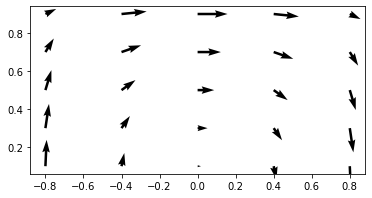

In [6]:
import matplotlib.pyplot as plt

u, v = velocity(xx, yy)

fig, ax = plt.subplots()
ax.quiver(xx,yy,u,v)
ax.set_aspect('equal')
plt.show()

In [142]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(2, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 1)
)

In [143]:
from fastprogress.fastprogress import master_bar, progress_bar
import math 

N_STEPS = 10000
N_SAMPLES = 200
N_SAMPLES_0 = 100

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()
mlp.train()
a = 10

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    x = torch.rand(N_SAMPLES)*2. - 1.
    y = torch.rand(N_SAMPLES)
    X = torch.stack([  
        x, 
        y,
    ], axis=-1)
    X.requires_grad = True
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdy = grads[:,0], grads[:,1]
    u, v = velocity(X[:,0], X[:,1])
    pde_loss = criterion(u*dpdx, - v*dpdy) 
    
    # optimize for boundary conditions
    # left
    y = torch.rand(N_SAMPLES_0)
    Y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0) - 1., 
        y,
    ], axis=-1)
    p_y0 = 1. - torch.ones(len(Y0))*math.tanh(a)
    y_y0 = mlp(Y0) 
    y0_loss = criterion(y_y0, p_y0.unsqueeze(1))
    # right
    Y1 = torch.stack([  
        torch.ones(N_SAMPLES_0), 
        y,
    ], axis=-1)
    p_y1 = 1. - torch.ones(len(Y1))*math.tanh(a)
    y_y1 = mlp(Y1) 
    y1_loss = criterion(y_y1, p_y1.unsqueeze(1))
    # top
    x = torch.rand(N_SAMPLES_0)*2. - 1.
    X1 = torch.stack([  
        x, 
        torch.ones(N_SAMPLES_0),
    ], axis=-1)
    p_x1 = 1. - torch.ones(len(X1))*math.tanh(a)
    y_x1 = mlp(X1) 
    x1_loss = criterion(y_x1, p_x1.unsqueeze(1))
    # bottom (left)
    x = torch.rand(N_SAMPLES_0) - 1.
    X00 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0),
    ], axis=-1)
    p_x00 = 1. + torch.tanh(a*(2.*x + 1.))
    y_x00 = mlp(X00) 
    x00_loss = criterion(y_x00, p_x00.unsqueeze(1))
    # bottom (right)
    x = torch.rand(N_SAMPLES_0)
    X01 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0),
    ], axis=-1)
    X01.requires_grad = True
    y_x01 = mlp(X01) 
    grads, = torch.autograd.grad(y_x01, X01, grad_outputs=y_x01.data.new(y_x01.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdy = grads[:,1]
    x01_loss = criterion(dpdy, torch.zeros(len(dpdy), 1))  

    bound_loss = x00_loss + y0_loss + y1_loss + x1_loss + x01_loss
    
    # update
    optimizer.zero_grad()
    loss = pde_loss + bound_loss
    loss.backward()
    optimizer.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} bound_loss {bound_loss.item():.5f}'


/home/juan/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [144]:
def run_mlp(Nx, Ny):
    x = np.linspace(-1,1,Nx)
    y = np.linspace(0,1,Ny)
    X = np.stack(np.meshgrid(x,y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float()
    mlp.eval()
    with torch.no_grad():
        p = mlp(X)
    return p, x

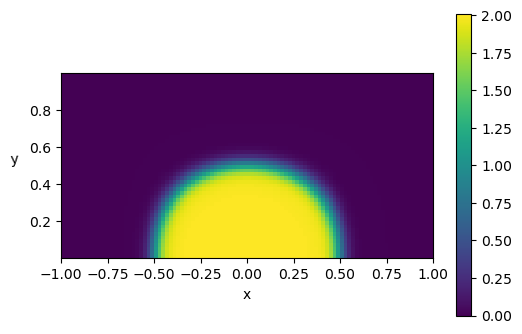

In [145]:
Nx, Ny = 100, 50
p, x = run_mlp(Nx, Ny)

plt.figure(dpi=100)
plt.imshow(p.reshape(Ny,Nx), vmin=p.min(), vmax=p.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel('x')
plt.ylabel('y    ', rotation=math.pi)
plt.colorbar()
plt.show()

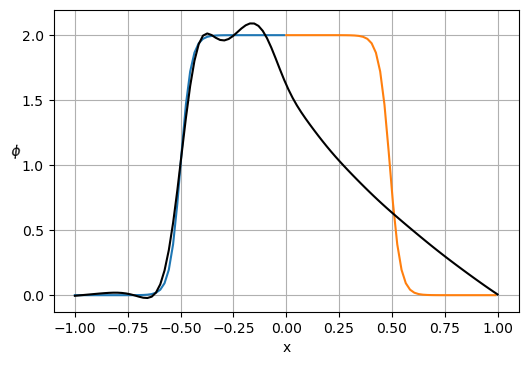

In [155]:
plt.figure(dpi=100)

x0 = x[x <= 0]
gt = 1. + np.tanh(a*(2*x0+1))

plt.plot(x0, gt)
plt.plot(x0 + 1., np.flip(gt))
plt.plot(x, p[:Nx], 'k')

plt.xlabel('x')
plt.ylabel('$\phi    $', rotation=math.pi)
plt.grid(True)
plt.show()

## Añadiendo viscosidad

$$
u \phi_x + v \phi_y = \Gamma (\phi_{xx} + \phi_{yy})
$$

In [150]:
mlp = nn.Sequential(
    nn.Linear(2, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 1)
)

In [151]:
N_STEPS = 10000
N_SAMPLES = 200
N_SAMPLES_0 = 100

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()
mlp.train()
a = 10
g = 0.1

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    x = torch.rand(N_SAMPLES)*2. - 1.
    y = torch.rand(N_SAMPLES)
    X = torch.stack([  
        x, 
        y,
    ], axis=-1)
    X.requires_grad = True
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdy = grads[:,0], grads[:,1]
    u, v = velocity(X[:,0], X[:,1])
    grads2, = torch.autograd.grad(dpdx, X, grad_outputs=dpdx.data.new(dpdx.shape).fill_(1), create_graph=True, only_inputs=True)
    dp2dx2 = grads2[:,0]
    grads2, = torch.autograd.grad(dpdy, X, grad_outputs=dpdy.data.new(dpdy.shape).fill_(1), create_graph=True, only_inputs=True)
    dp2dy2 = grads2[:,1]
    pde_loss = criterion(u*dpdx + v*dpdy, g*(dp2dx2 + dp2dy2)) 
    
    # optimize for boundary conditions
    # left
    y = torch.rand(N_SAMPLES_0)
    Y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0) - 1., 
        y,
    ], axis=-1)
    p_y0 = 1. - torch.ones(len(Y0))*math.tanh(a)
    y_y0 = mlp(Y0) 
    y0_loss = criterion(y_y0, p_y0.unsqueeze(1))
    # right
    Y1 = torch.stack([  
        torch.ones(N_SAMPLES_0), 
        y,
    ], axis=-1)
    p_y1 = 1. - torch.ones(len(Y1))*math.tanh(a)
    y_y1 = mlp(Y1) 
    y1_loss = criterion(y_y1, p_y1.unsqueeze(1))
    # top
    x = torch.rand(N_SAMPLES_0)*2. - 1.
    X1 = torch.stack([  
        x, 
        torch.ones(N_SAMPLES_0),
    ], axis=-1)
    p_x1 = 1. - torch.ones(len(X1))*math.tanh(a)
    y_x1 = mlp(X1) 
    x1_loss = criterion(y_x1, p_x1.unsqueeze(1))
    # bottom (left)
    x = torch.rand(N_SAMPLES_0) - 1.
    X00 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0),
    ], axis=-1)
    p_x00 = 1. + torch.tanh(a*(2.*x + 1.))
    y_x00 = mlp(X00) 
    x00_loss = criterion(y_x00, p_x00.unsqueeze(1))
    # bottom (right)
    x = torch.rand(N_SAMPLES_0)
    X01 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0),
    ], axis=-1)
    X01.requires_grad = True
    y_x01 = mlp(X01) 
    grads, = torch.autograd.grad(y_x01, X01, grad_outputs=y_x01.data.new(y_x01.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdy = grads[:,1]
    x01_loss = criterion(dpdy, torch.zeros(len(dpdy), 1))  

    bound_loss = x00_loss + y0_loss + y1_loss + x1_loss + x01_loss
    
    # update
    optimizer.zero_grad()
    loss = pde_loss + bound_loss
    loss.backward()
    optimizer.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} bound_loss {bound_loss.item():.5f}'

/home/juan/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


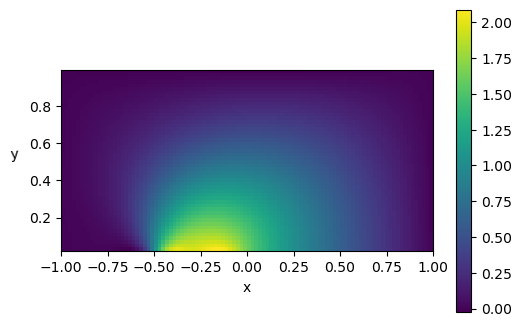

In [152]:
Nx, Ny = 100, 50
p, x = run_mlp(Nx, Ny)

plt.figure(dpi=100)
plt.imshow(p.reshape(Ny,Nx), vmin=p.min(), vmax=p.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel('x')
plt.ylabel('y    ', rotation=math.pi)
plt.colorbar()
plt.show()

In [154]:
# experimental results

exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

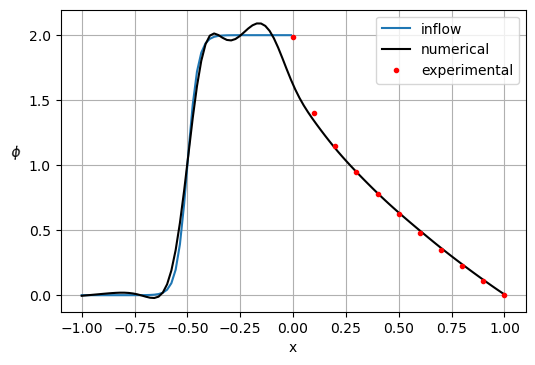

In [162]:
plt.figure(dpi=100)

x0 = x[x <= 0]
gt = 1. + np.tanh(a*(2*x0+1))

plt.plot(x0, gt)
plt.plot(x, p[:Nx], 'k')
plt.plot(exp['x'], exp['g_0.1'], '.r')

plt.xlabel('x')
plt.ylabel('$\phi$    ', rotation=math.pi)
plt.grid(True)
plt.legend(['inflow', 'numerical', 'experimental'])
plt.show()